In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Load EMNIST Balanced (62 kelas: 0-9, A-Z, a-z)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Normalisasi & reshape
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis=-1)  # from (28,28) to (28,28,1)
    return image, label

batch_size = 256
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Model CNN sederhana
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation='softmax')  # 62 class (0–9 + A–Z + a–z)
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Latih model
model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test
)

# Simpan model
model.save("emnist_model.h5")
print("✅ Model berhasil disimpan sebagai emnist_model.h5")


ImportError: cannot import name 'array_record_module' from 'array_record.python' (c:\Users\santo\anaconda3\envs\DIP\lib\site-packages\array_record\python\__init__.py)

1/1 [==============================] - 0s 43ms/step


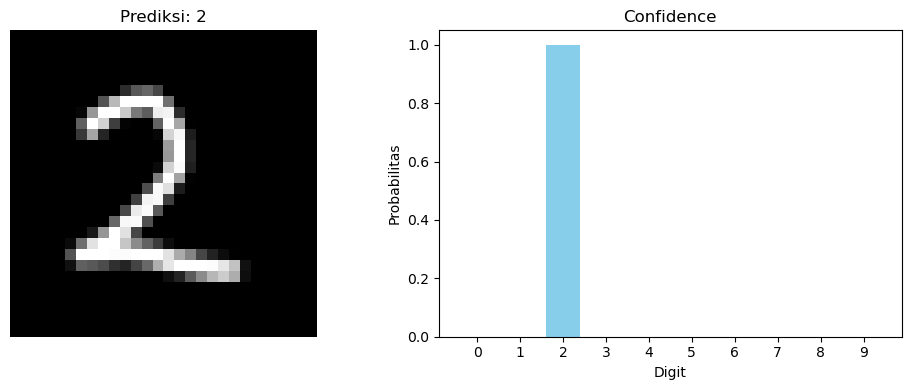

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load model
model = load_model("mnist_model.h5")

# Setup Tkinter Canvas
canvas_width = 280
canvas_height = 280
image1 = Image.new("L", (canvas_width, canvas_height), 255)
draw = ImageDraw.Draw(image1)

def paint(event):
    x1, y1 = (event.x - 8), (event.y - 8)
    x2, y2 = (event.x + 8), (event.y + 8)
    canvas.create_oval(x1, y1, x2, y2, fill='black', width=15)
    draw.ellipse([x1, y1, x2, y2], fill=0)

def clear_canvas():
    canvas.delete("all")
    draw.rectangle([0, 0, canvas_width, canvas_height], fill=255)

def predict_digit():
    # Resize dan normalisasi
    img = image1.resize((28, 28))
    img = ImageOps.invert(img)
    img = np.array(img).astype("float32") / 255.0
    img = img.reshape(1, 28, 28, 1)
    
    # Prediksi angka
    prediction = model.predict(img)[0]
    predicted_digit = np.argmax(prediction)

    # Tampilkan hasil
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Prediksi: {predicted_digit}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.bar(range(10), prediction, color='skyblue')
    plt.title("Confidence")
    plt.xlabel("Digit")
    plt.ylabel("Probabilitas")
    plt.xticks(range(10))
    plt.tight_layout()
    plt.show()

# GUI Tkinter
root = tk.Tk()
root.title("Digit Recognizer")

canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg='white')
canvas.pack()

canvas.bind("<B1-Motion>", paint)

btn_predict = tk.Button(root, text="Prediksi", command=predict_digit)
btn_predict.pack(side=tk.LEFT)

btn_clear = tk.Button(root, text="Bersihkan", command=clear_canvas)
btn_clear.pack(side=tk.LEFT)

root.mainloop()
